<a href="https://colab.research.google.com/github/LakshminarayananLaksh/demo/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install librosa soundfile numpy sklearn

In [ ]:

import soundfile
import numpy as np
import glob
import os
import re
import sys
import librosa
import librosa.display
from random import shuffle
from typing import Tuple
import pickle
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pickle
import matplotlib.pyplot as plt
import IPython.display


In [ ]:
# all emotions on RAVDESS dataset
init_emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these  four emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "happy",
    "neutral"
}


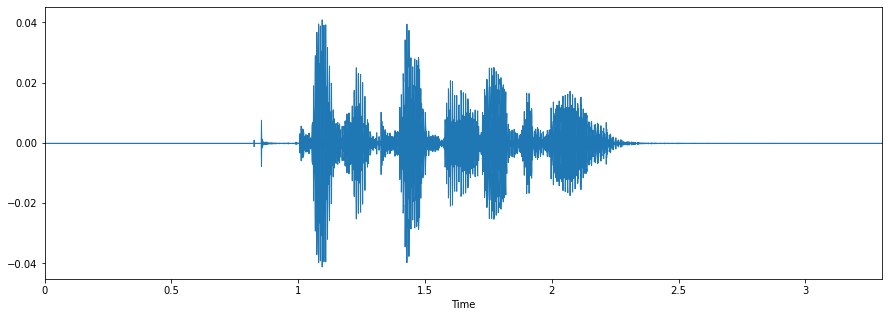

In [ ]:
data, sampling_rate = librosa.load('/content/drive/My Drive/Dataset/Actor_01/03-01-01-01-01-01-01.wav')


plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
def features(file):

    X, sample_rate = librosa.load(file, sr = None)

    print(sample_rate)
    max_ = X.shape[0] / sample_rate

    return extract_features(X, sample_rate)



In [ ]:
def extract_features(X, sample_rate):

    stft = np.abs(librosa.stft(X))

    extract_features = np.array([])


    pitches, magnitudes = librosa.piptrack(X, sr=sample_rate, S=stft, fmin=70, fmax=400)
    pitch = []
    for i in range(magnitudes.shape[1]):
        index = magnitudes[:, 1].argmax()
        pitch.append(pitches[index, i])

    pitch_tuning_offset = librosa.pitch_tuning(pitches)
    pitchmean = np.mean(pitch)
    pitchstd = np.std(pitch)
    pitchmax = np.max(pitch)
    pitchmin = np.min(pitch)


    cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    cent = cent / np.sum(cent)
    meancent = np.mean(cent)
    stdcent = np.std(cent)
    maxcent = np.max(cent)


    flatness = np.mean(librosa.feature.spectral_flatness(y=X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    zerocr = np.mean(librosa.feature.zero_crossing_rate(X))

    S, phase = librosa.magphase(stft)
    meanMagnitude = np.mean(S)
    stdMagnitude = np.std(S)
    maxMagnitude = np.max(S)
    rmse = librosa.feature.rmse(S=S)[0]
    meanrms = np.mean(rmse)
    stdrms = np.std(rmse)
    maxrms = np.max(rmse)

    ext_features = np.array([
        flatness, zerocr,

    ])

    ext_features = np.concatenate((ext_features, mfccs,mfccsstd, mfccmax,chroma, mel))




    return ext_features

In [ ]:
def envelope(y, sr, threshold):
    mask = []
    y_abs = pd.Series(y).apply(np.abs)
    y_mean = y_abs.rolling(window = int(sr/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(y[mask])

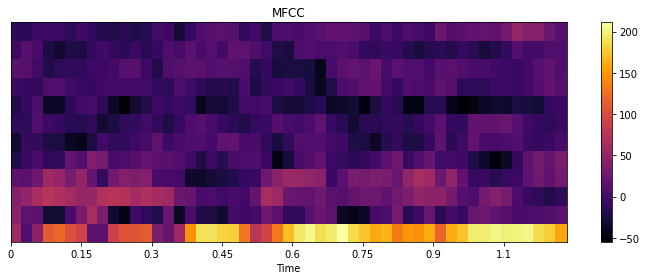

In [ ]:
# Actor 1, male, very happy
filename = '/content/drive/My Drive/Dataset/Actor_01/03-01-01-01-01-01-01.wav'

y1, sr = librosa.load(filename)

y1 = envelope(y1, sr, 0.0005)

mfcc1 = librosa.feature.mfcc(y1,sr,n_mfcc = 50, n_fft = 552, hop_length = 552)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc1[1:13], x_axis='time', cmap = 'inferno')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show();

In [ ]:
y1.shape[0]/sr

1.2673015873015874

In [ ]:
mfcc1.shape[1] * 1/40

1.275

In [ ]:

IPython.display.Audio(y1, rate=sr)

Tempo: 151.99908088235293BPM


/usr/local/lib/python3.6/dist-packages/librosa/beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


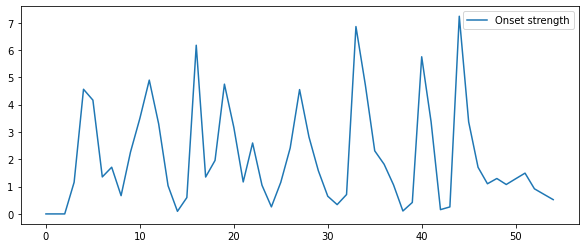

In [ ]:
# Compute local onset autocorrelation
oenv1 = librosa.onset.onset_strength(y=y1, sr=sr)

# Estimate the global tempo for display purposes
tempo1 = librosa.beat.tempo(onset_envelope=oenv1, sr=sr)[0]

print("Tempo: " + str(tempo1) + "BPM")

plt.figure(figsize=(10, 4))
plt.plot(oenv1, label='Onset strength')
plt.legend(frameon=True)
plt.axis('tight');

In [ ]:
def load_data():

    X, y = [], []

    for file in glob.glob("/content/drive/My Drive/Dataset/Actor_*/*.wav"):
          # get the base name of the audio file
        basename = os.path.basename(file)
        print(basename)
          # get the emotion label
        emotion = init_emotions[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
              continue# we allow only AVAILABLE_EMOTIONS we set

        test_features = features(file)
         # add to data
        X.append(test_features)
        y.append(emotion)

    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=0.25,random_state = 9)

In [ ]:
X_train, X_test, y_train, y_test = load_data()


03-01-04-02-01-02-15.wav
48000
03-01-01-01-01-01-15.wav
48000
03-01-03-02-01-02-15.wav
48000
03-01-06-02-02-01-15.wav
03-02-06-02-02-02-15.wav
03-02-06-01-02-01-15.wav
03-01-07-01-01-02-15.wav
03-01-06-01-02-02-15.wav
03-02-06-02-01-02-15.wav
03-01-02-02-01-02-15.wav
03-02-04-01-02-02-15.wav
48000
03-02-03-01-01-01-15.wav
48000
03-02-03-01-01-02-15.wav
48000
03-01-03-01-02-02-15.wav
48000
03-01-05-02-02-02-15.wav
48000
03-01-04-01-02-01-15.wav
48000
03-01-04-02-02-02-15.wav
48000
03-02-04-02-02-02-15.wav
48000
03-01-04-01-01-01-15.wav
48000
03-01-04-01-02-02-15.wav
48000
03-01-05-02-01-02-15.wav
48000
03-02-03-01-02-01-15.wav
48000
03-02-03-01-02-02-15.wav
48000
03-02-03-02-02-02-15.wav
48000
03-01-01-01-01-02-15.wav
48000
03-01-07-01-02-02-15.wav
03-02-02-02-01-01-15.wav
03-01-05-01-01-02-15.wav
48000
03-01-08-01-01-01-15.wav
03-01-04-02-01-01-15.wav
48000
03-01-07-02-02-02-15.wav
03-01-07-02-01-02-15.wav
03-01-08-02-01-02-15.wav
03-01-07-02-02-01-15.wav
03-01-02-01-01-02-15.wav
03-02

In [ ]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted
# using utils.extract_features() method
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 987
[+] Number of testing samples: 329
[+] Number of features: 292


In [ ]:
#MULTI-LAYER PRECEPTRON
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (400,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
model = MLPClassifier(**model_params)

# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

# predict 25% of data to measure how good we are
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))
MLP_Report = classification_report(y_test,y_pred)
print(MLP_Report)
# creating a confusion matrix
print(confusion_matrix(y_test, y_pred))

[*] Training the model...
Accuracy: 81.16%
              precision    recall  f1-score   support

       angry       0.92      0.92      0.92        95
       happy       0.82      0.82      0.82       111
     neutral       1.00      0.41      0.58        37
         sad       0.69      0.86      0.76        86

    accuracy                           0.81       329
   macro avg       0.86      0.75      0.77       329
weighted avg       0.83      0.81      0.81       329

[[87  5  0  3]
 [ 8 91  0 12]
 [ 0  3 15 19]
 [ 0 12  0 74]]


In [ ]:
#support vector machine
svm_model_rbf = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr',
                       degree=3, gamma=0.0001, kernel = 'rbf', max_iter=-1, probability= False, random_state= None,
                       shrinking=True, tol=0.001, verbose=False).fit(X_train, y_train)
svm_predictions = svm_model_rbf.predict(X_test)

SVM_Accuracy = accuracy_score(y_true=y_test,y_pred=svm_predictions)
print(SVM_Accuracy)
SVM_Report = classification_report(y_test,svm_predictions)
print(SVM_Report)
# creating a confusion matrix
print(confusion_matrix(y_test, svm_predictions) )

0.8723404255319149
              precision    recall  f1-score   support

       angry       0.88      0.97      0.92        95
       happy       0.89      0.83      0.86       111
     neutral       0.86      0.84      0.85        37
         sad       0.85      0.84      0.84        86

    accuracy                           0.87       329
   macro avg       0.87      0.87      0.87       329
weighted avg       0.87      0.87      0.87       329

[[92  2  0  1]
 [ 8 92  2  9]
 [ 1  2 31  3]
 [ 4  7  3 72]]


In [ ]:
"""DECISION TREE """
dt_params = {'criterion': 'entropy',
             'max_depth': 6,
             'min_samples_leaf': 4,
             'min_samples_split': 23,
             'max_leaf_nodes': 169}
dtree_model = DecisionTreeClassifier(**dt_params).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
DT_accuracy = accuracy_score(y_true=y_test,y_pred=dtree_predictions)
print(DT_accuracy)
DT_Report = classification_report(y_test,dtree_predictions)
print(DT_Report)
# creating a confusion matrix
print(confusion_matrix(y_test, dtree_predictions) )


0.6534954407294833
              precision    recall  f1-score   support

       angry       0.71      0.73      0.72        95
       happy       0.66      0.64      0.65       111
     neutral       0.63      0.59      0.61        37
         sad       0.59      0.62      0.60        86

    accuracy                           0.65       329
   macro avg       0.65      0.64      0.65       329
weighted avg       0.65      0.65      0.65       329

[[69 19  0  7]
 [19 71  3 18]
 [ 0  3 22 12]
 [ 9 14 10 53]]


In [ ]:
""" random forest """

from sklearn.ensemble import RandomForestClassifier

rf_params = {'criterion': 'entropy',
             'max_depth': 15}
classifier = RandomForestClassifier(**rf_params)

# fit the regressor with x and y data
classifier.fit(X_train, y_train)


c_p = classifier.predict(X_test)

RF_accuracy = accuracy_score(y_true=y_test,y_pred=c_p)
print(RF_accuracy)
RF_Report = classification_report(y_test,c_p)
print(RF_Report)
# creating a confusion matrix
print(confusion_matrix(y_test,c_p) )

0.8024316109422492
              precision    recall  f1-score   support

       angry       0.83      0.91      0.87        95
       happy       0.84      0.73      0.78       111
     neutral       1.00      0.62      0.77        37
         sad       0.70      0.86      0.77        86

    accuracy                           0.80       329
   macro avg       0.84      0.78      0.80       329
weighted avg       0.82      0.80      0.80       329

[[86  7  0  2]
 [14 81  0 16]
 [ 0  0 23 14]
 [ 3  9  0 74]]


In [ ]:
"""XGB"""

from xgboost import XGBClassifier
xgb_params = {'booster': 'gbtree',
              'lambda': 7.201651687969849e-08,
              'alpha': 2.2495125443474775e-05,
              'max_depth': 7,
              'eta': 9.307925211476325e-06,
              'gamma': 1.7948741419263195e-05,
              'grow_policy': 'lossguide'}

mod= XGBClassifier(**xgb_params).fit(X_train, y_train)

Xb=mod.predict(X_test)
XGB_Accuracy = accuracy_score(y_true=y_test,y_pred=Xb)

print(XGB_Accuracy)
XGB_Report = classification_report(y_test,Xb)
print(XGB_Report)
# creating a confusion matrix
print(confusion_matrix(y_test,Xb) )


0.8358662613981763
              precision    recall  f1-score   support

       angry       0.84      0.94      0.89        95
       happy       0.88      0.78      0.83       111
     neutral       0.87      0.70      0.78        37
         sad       0.78      0.85      0.81        86

    accuracy                           0.84       329
   macro avg       0.84      0.82      0.83       329
weighted avg       0.84      0.84      0.83       329

[[89  4  0  2]
 [12 87  2 10]
 [ 1  1 26  9]
 [ 4  7  2 73]]


In [ ]:
import matplotlib.pyplot as plt
results = [accuracy,SVM_Accuracy,DT_accuracy,RF_accuracy,XGB_Accuracy]
Names   =[ 'MLP Classifier', 'SVM', 'Decision Tree', 'Random Forest', 'XGB']

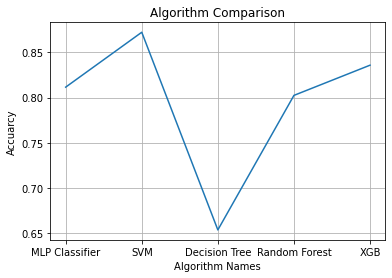

In [ ]:
plt.plot(Names, results)
plt.title("Algorithm Comparison")
plt.xlabel("Algorithm Names")
plt.ylabel("Accuarcy")
plt.grid()
plt.show()

PREDICT

In [ ]:
X, sample_rate = librosa.load('/content/drive/My Drive/Colab Notebooks/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-02-01-01.wav',sr= None)


stft = np.abs(librosa.stft(X))
flatness = np.mean(librosa.feature.spectral_flatness(y=X))
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
zerocr = np.mean(librosa.feature.zero_crossing_rate(X))

ext_featuress = np.array([
        flatness, zerocr
    ])
ext_featuress = np.concatenate((ext_featuress, mfccs, mfccsstd, mfccmax, chroma, mel))
livedf2 = ext_featuress

In [ ]:
livedf2= pd.DataFrame(data=livedf2)

In [ ]:
livedf2 = livedf2.stack().to_frame().T

In [ ]:
livedf2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.22372,0.066511,-677.770909,51.448648,0.025513,14.331259,0.793491,-0.217088,-6.153233,-10.726823,-7.602886,1.301076,-3.803666,1.963046,-5.7317,0.404974,-2.481751,-5.35877,-1.391952,0.853431,-5.603844,-2.016019,-2.211001,-4.334707,-0.27026,-2.787744,-2.864479,-1.034408,-1.742255,-0.80528,-3.127946,-2.060846,-2.590882,-2.652149,-1.988784,-1.423693,-4.326625,-2.718752,-3.028184,-1.541225,...,0.000097,0.000141,0.000234,0.000439,0.000508,0.000563,0.000407,0.000197,0.000113,0.00012,0.000069,0.000055,0.000096,0.000108,0.000315,0.000369,0.000245,0.000395,0.000776,0.000635,0.000314,0.000226,0.000166,0.000117,0.000085,0.000117,0.000066,0.000117,0.000113,0.000111,0.000068,0.000042,0.000023,0.00003,0.000025,0.00002,0.000013,0.00001,0.000005,0.000002


In [ ]:
livepred= svm_model_rbf.predict(livedf2)

In [ ]:
livepred

array(['happy'], dtype='<U7')